# Pd1 Jamroży Bartosz

In [78]:
library(tidyverse)
library(reshape2)

library(DALEX)
library(DALEXtra)

options(warn=-1)

## Dane
z: https://www.kaggle.com/camnugent/california-housing-prices

In [11]:
house <- read.csv(file = 'housing.csv', stringsAsFactors = FALSE)
head(house)
nrow(house)

longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
-122.23,37.88,41,880,129,322,126,8.3252,452600,NEAR BAY
-122.22,37.86,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY
-122.24,37.85,52,1467,190,496,177,7.2574,352100,NEAR BAY
-122.25,37.85,52,1274,235,558,219,5.6431,341300,NEAR BAY
-122.25,37.85,52,1627,280,565,259,3.8462,342200,NEAR BAY
-122.25,37.85,52,919,213,413,193,4.0368,269700,NEAR BAY


[1] 20640

## Opis
1. longitude: A measure of how far west a house is; a higher value is farther west

2. latitude: A measure of how far north a house is; a higher value is farther north

3. housingMedianAge: Median age of a house within a block; a lower number is a newer building

4. totalRooms: Total number of rooms within a block

5. totalBedrooms: Total number of bedrooms within a block

6. population: Total number of people residing within a block

7. households: Total number of households, a group of people residing within a home unit, for a block

8. medianIncome: Median income for households within a block of houses (measured in tens of thousands of US Dollars)

9. medianHouseValue: Median house value for households within a block (measured in US Dollars)

10. oceanProximity: Location of the house w.r.t ocean/sea

In [12]:
summary(house)

   longitude         latitude     housing_median_age  total_rooms   
 Min.   :-124.3   Min.   :32.54   Min.   : 1.00      Min.   :    2  
 1st Qu.:-121.8   1st Qu.:33.93   1st Qu.:18.00      1st Qu.: 1448  
 Median :-118.5   Median :34.26   Median :29.00      Median : 2127  
 Mean   :-119.6   Mean   :35.63   Mean   :28.64      Mean   : 2636  
 3rd Qu.:-118.0   3rd Qu.:37.71   3rd Qu.:37.00      3rd Qu.: 3148  
 Max.   :-114.3   Max.   :41.95   Max.   :52.00      Max.   :39320  
                                                                    
 total_bedrooms     population      households     median_income    
 Min.   :   1.0   Min.   :    3   Min.   :   1.0   Min.   : 0.4999  
 1st Qu.: 296.0   1st Qu.:  787   1st Qu.: 280.0   1st Qu.: 2.5634  
 Median : 435.0   Median : 1166   Median : 409.0   Median : 3.5348  
 Mean   : 537.9   Mean   : 1425   Mean   : 499.5   Mean   : 3.8707  
 3rd Qu.: 647.0   3rd Qu.: 1725   3rd Qu.: 605.0   3rd Qu.: 4.7432  
 Max.   :6445.0   Max.   :35682   

total_bedrooms posiada 207 brakójących wartosci ok 1% całości, oraz jedną kolumne kategoryczną ocean_proximity


# Model


przykładowy model z : https://www.kaggle.com/camnugent/introduction-to-machine-learning-in-r-tutorial

In [70]:
library(tidyverse)
library(reshape2)

housing = read.csv("housing.csv")

# par(mfrow=c(2,5))

# clean data
housing$total_bedrooms[is.na(housing$total_bedrooms)] = median(housing$total_bedrooms , na.rm = TRUE)

#Fix the total columns - make them means
housing$mean_bedrooms = housing$total_bedrooms/housing$households
housing$mean_rooms = housing$total_rooms/housing$households

drops = c('total_bedrooms', 'total_rooms')
housing = housing[ , !(names(housing) %in% drops)]

#Turn categoricals into booleans
categories = unique(housing$ocean_proximity)

#split the categories off
cat_housing = data.frame(ocean_proximity = housing$ocean_proximity)

for(cat in categories){
  cat_housing[,cat] = rep(0, times= nrow(cat_housing))
}


for(i in 1:length(cat_housing$ocean_proximity)){
  cat = as.character(cat_housing$ocean_proximity[i])
  cat_housing[,cat][i] = 1
}

cat_columns = names(cat_housing)
keep_columns = cat_columns[cat_columns != 'ocean_proximity']
cat_housing = select(cat_housing,one_of(keep_columns))

#Scale the numerical variables

drops = c('ocean_proximity','median_house_value')
housing_num =  housing[ , !(names(housing) %in% drops)]

scaled_housing_num = scale(housing_num)

#Merge the altered numerical and categorical dataframes
cleaned_housing = cbind(cat_housing, scaled_housing_num, median_house_value=housing$median_house_value)


# Create a test set of data

set.seed(1738) # Set a random seed so that same sample can be reproduced in future runs

sample = sample.int(n = nrow(cleaned_housing), size = floor(.8*nrow(cleaned_housing)), replace = F)
train = cleaned_housing[sample, ] #just the samples
test  = cleaned_housing[-sample, ] #everything but the samples

#Random forest model
library('randomForest')

set.seed(1738)

train_y = train[,'median_house_value']
train_x = train[, names(train) !='median_house_value']

rf_model = randomForest(train_x, y = train_y , ntree = 500, importance = TRUE)

names(rf_model)
rf_model$importance

[1] "call"            "type"            "predicted"       "mse"            
 [5] "rsq"             "oob.times"       "importance"      "importanceSD"   
 [9] "localImportance" "proximity"       "ntree"           "mtry"           
[13] "forest"          "coefs"           "y"               "test"           
[17] "inbag"

,%IncMSE,IncNodePurity
NEAR BAY,486443080,1.312625e+12
<1H OCEAN,1621072507,4.289632e+12
INLAND,4045427703,3.068877e+13
NEAR OCEAN,539828604,2.299546e+12
ISLAND,1524086,6.496858e+10
longitude,6897270047,2.572075e+13
latitude,5710904041,2.255767e+13
housing_median_age,1082226582,9.661389e+12
population,1066423080,7.341037e+12
households,1193112832,7.923472e+12


Stworzony model to las losowy. <br>
Braki w danych (kolumna total_bedrooms) zostały uzupełnione przez medianę wszystkich wartości. <br>
Ilość sypialni, oraz pokoi w „bloku” zostały zastąpione ilością przypadającą na jednego mieszkańca. <br>
Kategoryczna kolumna ocean_proximity została rokodowana poprzez One-hot encoding. <br>
Kolumny numeryczne zostały przeskalowane.


## Wyjaśnianie

### Tworzenie explainera

In [71]:

y = cleaned_housing[,'median_house_value']
x = cleaned_housing[, names(train) !='median_house_value']

fr_model_expain <- explain(model = rf_model, data=x, y=y)


Preparation of a new explainer is initiated
  -> model label       :  randomForest  (  default  )
  -> data              :  20640  rows  13  cols 
  -> target variable   :  20640  values 
  -> predict function  :  yhat.randomForest  will be used (  default  )
  -> predicted values  :  No value for predict function target column. (  default  )
  -> model_info        :  package randomForest , ver. 4.6.14 , task regression (  default  ) 
  -> predicted values  :  numerical, min =  39702.65 , mean =  207032.6 , max =  499518.2  
  -> residual function :  difference between y and yhat (  default  )
  -> residuals         :  numerical, min =  -310541.6 , mean =  -176.7656 , max =  337753.4  
  A new explainer has been created!  


Ramka cleande_housing jest przeskalowana, weźmy ramke nieskalowaną dla lepszego zrozumienia zmiennych.

In [16]:
housing_not_scaled = cbind(cat_housing, housing_num, median_house_value=housing$median_house_value)
head(housing_not_scaled)

NEAR BAY,<1H OCEAN,INLAND,NEAR OCEAN,ISLAND,longitude,latitude,housing_median_age,population,households,median_income,mean_bedrooms,mean_rooms,median_house_value
1,0,0,0,0,-122.23,37.88,41,322,126,8.3252,1.0238095,6.984127,452600
1,0,0,0,0,-122.22,37.86,21,2401,1138,8.3014,0.9718805,6.238137,358500
1,0,0,0,0,-122.24,37.85,52,496,177,7.2574,1.0734463,8.288136,352100
1,0,0,0,0,-122.25,37.85,52,558,219,5.6431,1.0730594,5.817352,341300
1,0,0,0,0,-122.25,37.85,52,565,259,3.8462,1.0810811,6.281853,342200
1,0,0,0,0,-122.25,37.85,52,413,193,4.0368,1.1036269,4.761658,269700


# SHAP

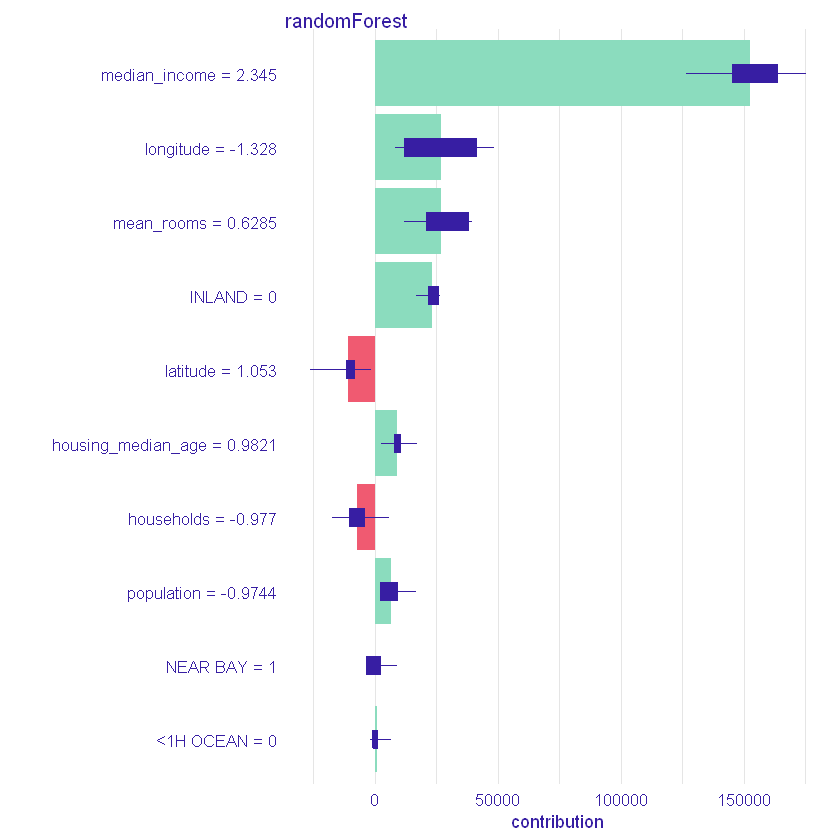

In [17]:
set.seed(1234)
rf_model_shap_1a <- predict_parts(fr_model_expain, new_observation = x[1,], type = "shap", B = 10)
plot(rf_model_shap_1a)

In [18]:
x[1,] # dane na kórych pracował model

NEAR BAY,<1H OCEAN,INLAND,NEAR OCEAN,ISLAND,longitude,latitude,housing_median_age,population,households,median_income,mean_bedrooms,mean_rooms
1,0,0,0,0,-1.327803,1.052523,0.9821189,-0.974405,-0.9770092,2.344709,-0.1485107,0.6285442


In [19]:
housing_not_scaled[1,] # dane nieprzeskalowane 

NEAR BAY,<1H OCEAN,INLAND,NEAR OCEAN,ISLAND,longitude,latitude,housing_median_age,population,households,median_income,mean_bedrooms,mean_rooms,median_house_value
1,0,0,0,0,-122.23,37.88,41,322,126,8.3252,1.02381,6.984127,452600


Wygenerowany wykres SHARP jest zależny od danego losowania, gdy weźmiemy inne ziarno otrzymamy inny wykres.

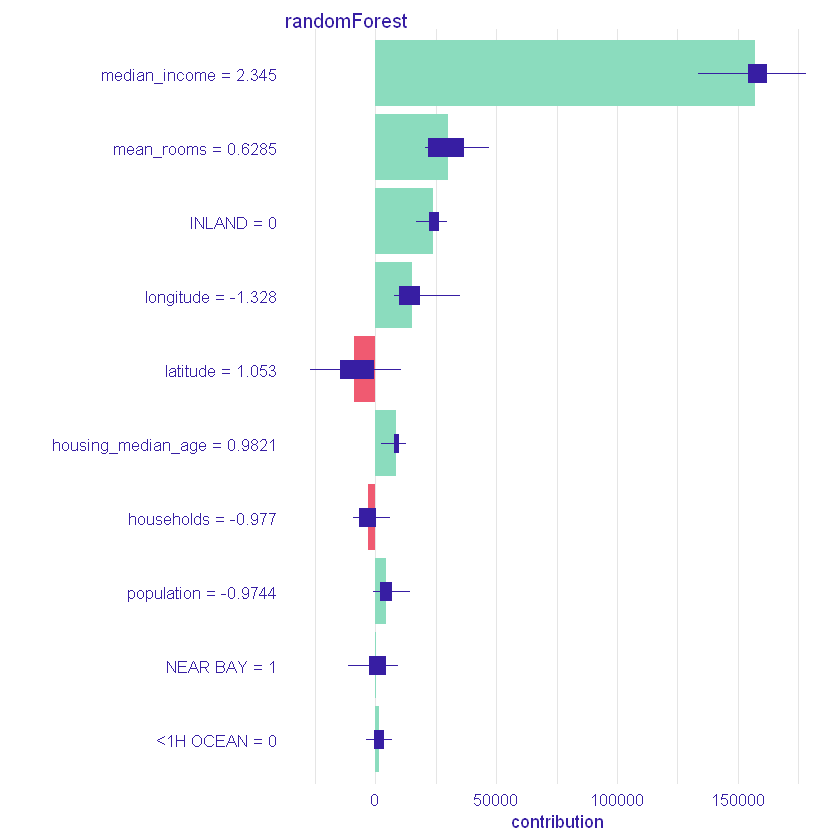

In [20]:
set.seed(5748)
rf_model_shap_1b <- predict_parts(fr_model_expain, new_observation = x[1,], type = "shap", B = 10)
plot(rf_model_shap_1b)

### Pierwsza nieruchomość w zbiorze:
Największy wpływ na podwyższenie przewidywanej ceny nieruchomości miała kategoria „median_income” (mediana z dochodów mieszkańców w okolicznym zgrupowaniu domów)
o wartości 83.252 tyś dolarów, jak na nasz zbiór jest to wysoka wartość 4-kwartyl. <br> 
Ludność więcej zarabiająca mieszka w droższych nieruchomościach. 

Mniejszy pozytywny efekt wykazały także długość geograficzna, średnia pokoi przypadająca na mieszkańca ok 7, oraz to że nieruchomość nie znajduje się na wyspie.    


W tym przypadku przeważą zmienne podnoszące cenę, jest to dość droga nieruchomość 4-kwartyl po cenie. 


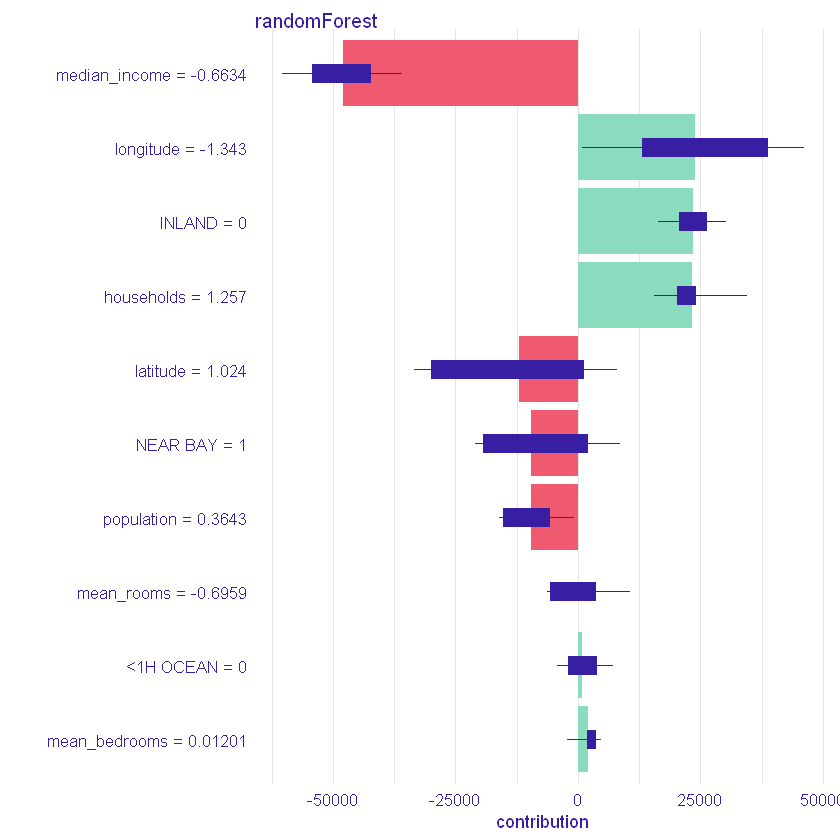

In [21]:
set.seed(5840)
rf_model_shap_2 <- predict_parts(fr_model_expain, new_observation = x[100,], type = "shap", B = 10)
plot(rf_model_shap_2)

In [22]:
x[100,] # dane na kórych pracował model

,NEAR BAY,<1H OCEAN,INLAND,NEAR OCEAN,ISLAND,longitude,latitude,housing_median_age,population,households,median_income,mean_bedrooms,mean_rooms
100,1,0,0,0,0,-1.342777,1.024432,0.6642943,0.3642711,1.256665,-0.6633628,0.01200532,-0.6959323


In [23]:
housing_not_scaled[100,] # dane nieprzeskalowane 

,NEAR BAY,<1H OCEAN,INLAND,NEAR OCEAN,ISLAND,longitude,latitude,housing_median_age,population,households,median_income,mean_bedrooms,mean_rooms,median_house_value
100,1,0,0,0,0,-122.26,37.82,37,1838,980,2.6104,1.107143,3.707143,193100


### Setna nieruchomość w zbiorze:
Największy wpływ na obniżenie przewidywanej ceny miał niski poziom dochodów na poziomie 26.104 tyś USD (pierwszy kwartyl dochodów).

Zaś pozytywny efekt wykazała długość geograficzna, oraz fakt że  nieruchomość nie znajduje się na wyspie.


## Obserwacje o różnych ważnych zmiennych mających wpływ na predykcje 

In [72]:
# jakaś obserwacja
predict_5 <- predict_parts(fr_model_expain, new_observation = x[5,])

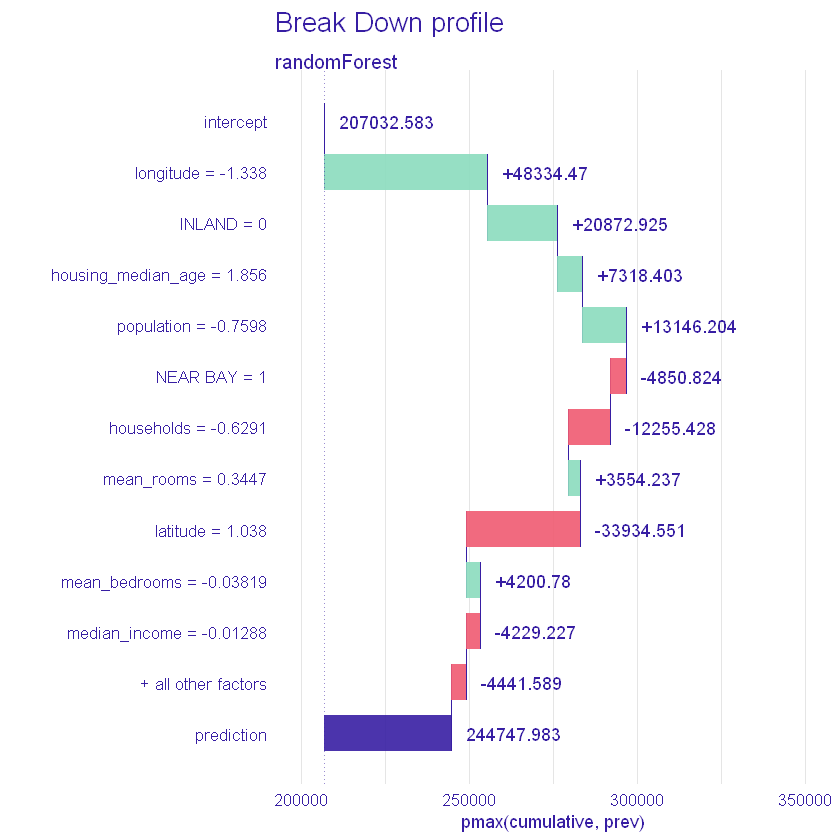

In [90]:
suppressMessages(plot(predict_5) + ylim(200000,350000))


Dla piątej obserwacji w predykcji ceny największe znaczenia miała długość geograficzna, oraz to że nie znajduje się na wyspie. 

In [36]:
# wybieranie losowych obserwacji, i sprawdzanie czy dwie głóne kategorie są inne

set.seed(1234)
while(TRUE){
  s=sample(1:nrow(x),1,replace = F)
  print(s)
  predict_s <- predict_parts(fr_model_expain, new_observation = x[s,])
  print(predict_s)
  if (predict_s[2,]$variable_name!=predict_5[2,]$variable_name & predict_s[2,]$variable_name!=predict_5[3,]$variable_name){
      if (predict_s[3,]$variable_name!=predict_5[3,]$variable_name & predict_s[3,]$variable_name!=predict_5[2,]$variable_name){
        return()
      }
  }
}

[1] 7452
                                           contribution
randomForest: intercept                      207032.583
randomForest: latitude = -0.7921              28393.338
randomForest: INLAND = 0                      28589.543
randomForest: median_income = 0.4044          19388.470
randomForest: population = -0.8181            16428.216
randomForest: households = -0.7782           -20699.419
randomForest: <1H OCEAN = 1                   -2388.232
randomForest: longitude = 0.6986             -67323.352
randomForest: housing_median_age = -0.9248    -2818.299
randomForest: NEAR BAY = 0                    -1048.903
randomForest: NEAR OCEAN = 0                  -3137.493
randomForest: mean_rooms = 0.09673            -8692.851
randomForest: mean_bedrooms = -0.1276         -6059.778
randomForest: ISLAND = 0                         -0.361
randomForest: prediction                     187663.460
[1] 8016
                                          contribution
randomForest: intercept        

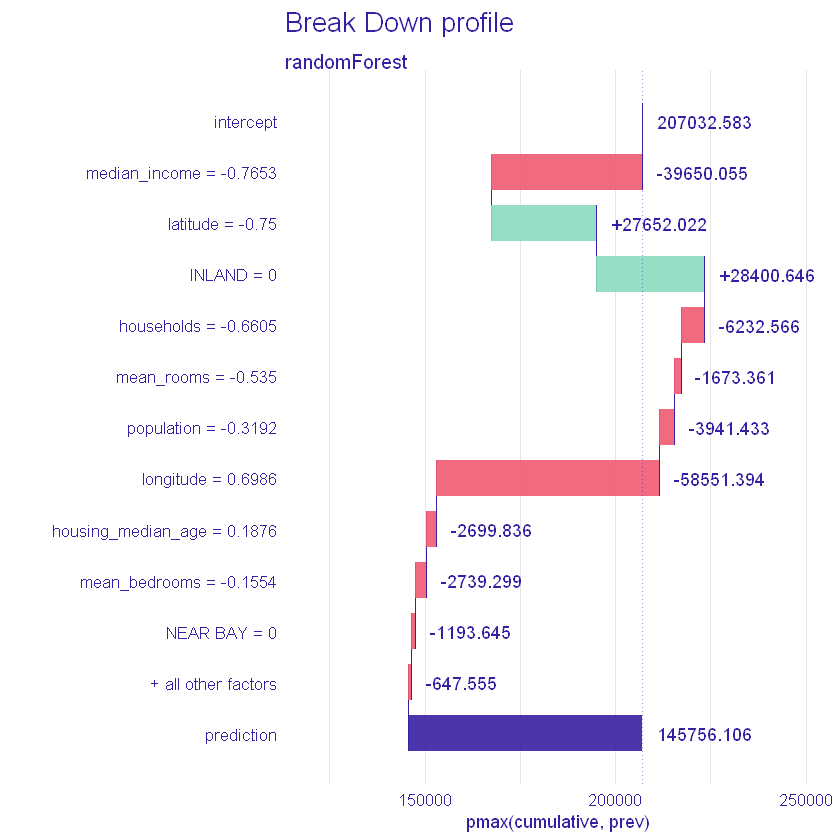

In [91]:
suppressMessages(plot(predict_s) + ylim(120000,250000))

W tym przypadku najważniejsza była  mediana dochodu oraz szerokość geograficzna.

We wszystkich powyższych przykładach, gdy nieruchomość nie jest zaklafikowana jako znajdujaca się w głebi lądu (INLAND=0) jej watorśc jest wyższa.

## Obserwacje  które mają dla tych samych zmiennych inne efekty (pozytywny i negatywny)

In [87]:
pp_1<-predict_parts(fr_model_expain, new_observation = x[18323,])


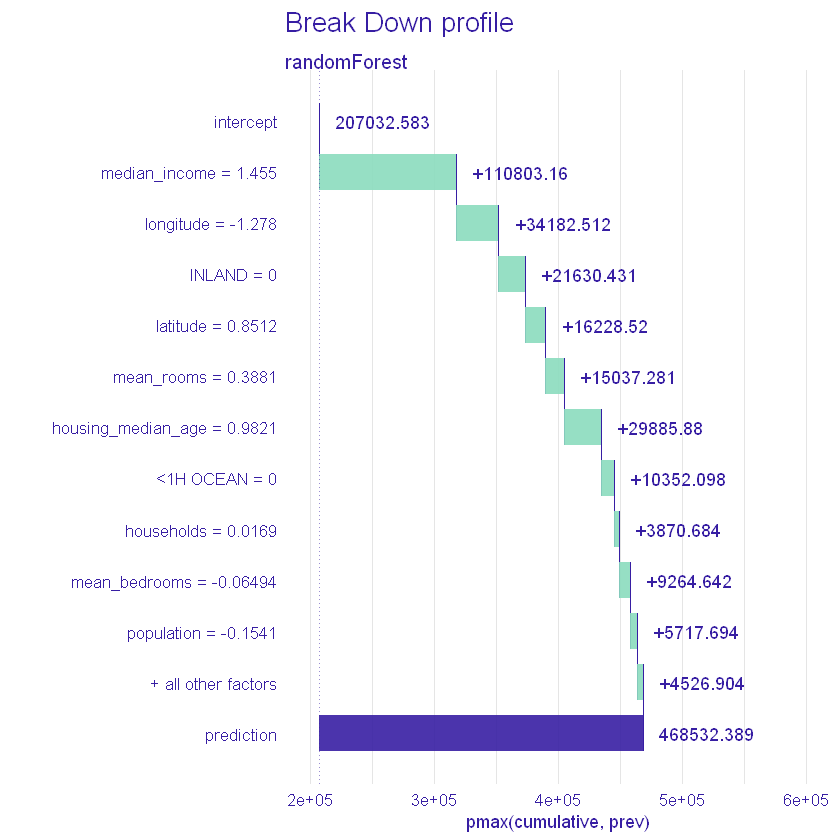

In [92]:
suppressMessages(plot(pp_1) + ylim(200000,600000))

In [28]:
housing_not_scaled[18323,] # dane nieprzeskalowane 

,NEAR BAY,<1H OCEAN,INLAND,NEAR OCEAN,ISLAND,longitude,latitude,housing_median_age,population,households,median_income,mean_bedrooms,mean_rooms,median_house_value
18323,1,0,0,0,0,-122.13,37.45,41,1251,506,6.6354,1.067194,6.389328,500001


In [89]:
pp_2<-predict_parts(fr_model_expain, new_observation = x[19577,])


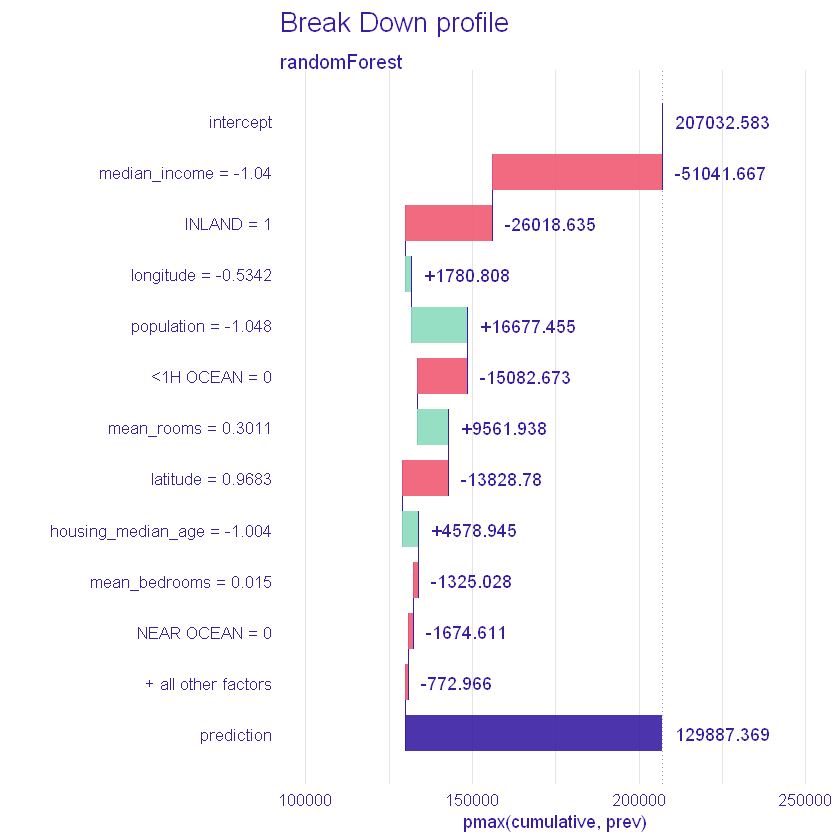

In [93]:
suppressMessages(plot(pp_2) + ylim(100000,250000))

In [30]:
housing_not_scaled[19577,] # dane nieprzeskalowane 

,NEAR BAY,<1H OCEAN,INLAND,NEAR OCEAN,ISLAND,longitude,latitude,housing_median_age,population,households,median_income,mean_bedrooms,mean_rooms,median_house_value
19577,0,0,1,0,0,-120.64,37.7,16,239,46,1.8958,1.108696,6.173913,137500


W dwóch powyższych przypadkach,te same kategorie różnie wpływały na przewidzianą cenę.


miedain_income : <br>
przypadek 1:  66.354 tyś USD <br>
przypadek 2:  18.958 tyś USD <br>
Niska mediana spowodowała obniżenie przewidywanej ceny. Zaś wysoka jej podwyższenie.
W obu przypadkach mediana zarobków miała znaczny wpływ na przewidywanie 


Latitude: <br>
przypadek 1:  37.45 <br>
przypadek 2:  37.7 <br>
Położenie bardziej na południe spowodowało dodanie wartości do przewidywanej, a północe jej obniżenie.

<1H OCEN <br>
Co ciekawe obie nieruchomości  należą do tej samej kategorii <1H OCEN (ponad godzinę drogi do oceanu), ale raz wpłynęło to negatywie na wysokość przewidywania a raz pozytywnie. 
